In [1]:
# ORIGINAL CODE : https://machinelearningmastery.com/weighted-average-ensemble-with-python/
# By Jason Brownlee - MAY 2021

# Modifed by MAHAYASA ADIPUTRA - OCT 2022
import time
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as mt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_predict
le = LabelEncoder()
start_time = time.time()
# get the dataset
# Importing the dataset
dataset=pd.read_csv('../../data/dataset1.csv')
dataset=dataset.dropna()
dataset=dataset.fillna(0)

#transform data into numeric value
dataset['Partner']=le.fit_transform(dataset['Partner'])
dataset['Dependents']=le.fit_transform(dataset['Dependents'])
dataset['PhoneService']=le.fit_transform(dataset['PhoneService'])
dataset['MultipleLines']=le.fit_transform(dataset['MultipleLines'])
dataset['InternetService']=le.fit_transform(dataset['InternetService'])
dataset['OnlineSecurity']=le.fit_transform(dataset['OnlineSecurity'])
dataset['DeviceProtection']=le.fit_transform(dataset['DeviceProtection'])
dataset['TechSupport']=le.fit_transform(dataset['TechSupport'])
dataset['StreamingTV']=le.fit_transform(dataset['StreamingTV'])
dataset['StreamingMovies']=le.fit_transform(dataset['StreamingMovies'])
dataset['Contract']=le.fit_transform(dataset['Contract'])
dataset['PaperlessBilling']=le.fit_transform(dataset['PaperlessBilling'])
dataset['PaymentMethod']=le.fit_transform(dataset['PaymentMethod'])
dataset['gender']=le.fit_transform(dataset['gender'])
dataset['OnlineBackup']=le.fit_transform(dataset['OnlineBackup'])

#filling missing value with mean
dataset['TotalCharges'].replace(to_replace = 0, value = dataset['TotalCharges'].mean(), inplace=True)
X=dataset.drop(['Churn','customerID'],axis=1)
y=dataset["Churn"]
y = le.fit_transform(y)
#imblearn SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

#kfold cross validation
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# get a list of base models
def get_models():
	models = list()
	models.append(('xb', XGBClassifier(colsample_bytree=0.6, max_depth = 5, gamma=1.5, min_child_weight=5)))
	models.append(('rf', RandomForestClassifier(n_estimators =100, criterion = 'gini', random_state = 0)))
#	models.append(('ab', AdaBoostClassifier(n_estimators=100,learning_rate=0.1,algorithm='SAMME.R')))
	return models
 
# evaluate each base model
def evaluate_models(models, X,y):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# evaluate the model
		acc=cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
		# store the performance
		scores.append(mean(acc))
		# report model performance
	return scores



# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X,y)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
score=cross_val_score(ensemble, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Weighted Avg AUC ROC: %.3f' % (mean(score)*100))
print('STD AUC ROC: %.3f' % (std(score)))
print("--- %s seconds ---" % (time.time() - start_time))

[0.9271625483858642, 0.9259501501198344]
Weighted Avg AUC ROC: 93.195
STD AUC ROC: 0.004
--- 9.193742036819458 seconds ---


<AxesSubplot:>

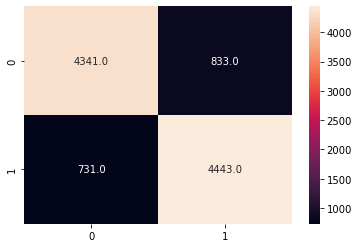

In [2]:
y_pred = cross_val_predict(ensemble, X, y, cv=cv)
import seaborn as sns
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True,fmt=".1f")


In [3]:
pr=cross_val_score(ensemble, X, y, scoring='precision', cv=cv, n_jobs=-1)
mean(pr)

0.8421804877820298

In [4]:
rc=cross_val_score(ensemble, X, y, scoring='recall', cv=cv, n_jobs=-1)
mean(rc)

0.8587657006070394

In [5]:
f1=cross_val_score(ensemble, X, y, scoring='f1', cv=cv, n_jobs=-1)
mean(f1)

0.8503307692172083

In [6]:
cm = confusion_matrix(y, y_pred)
cm

array([[4341,  833],
       [ 731, 4443]], dtype=int64)

In [7]:
roc_curve(y, y_pred)

(array([0.        , 0.16099729, 1.        ]),
 array([0.        , 0.85871666, 1.        ]),
 array([2, 1, 0]))

In [8]:
roc_curve(y, y_pred)

(array([0.        , 0.16099729, 1.        ]),
 array([0.        , 0.85871666, 1.        ]),
 array([2, 1, 0]))

In [20]:
data=dataset[dataset['Churn']=='No']

In [21]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
